In [1]:
from glob import glob
import re 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from os.path import join

In [2]:
exproot="/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
exproot="/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
# sorted(glob(join(exproot, "*"))) # parse the expname for those matching 045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256' or 080...
expnames = [os.path.basename(exp) for exp in sorted(glob(join(exproot, "*")))]

In [3]:
expnames # find the matching patterns 045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256' or 080...
expnames_filtered = []
for expname in expnames:
    m = re.match(r"(\d+)-RAVEN10_abstract", expname)
    # if the number id > 61
    if m and int(m.group(1)) >= 45:
        expnames_filtered.append(expname)

In [4]:
expnames_filtered

['045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256',
 '046-RAVEN10_abstract-cond-DiT_S_1_20240311-1256',
 '047-RAVEN10_abstract-cond-DiT_B_1_20240311-1259',
 '048-RAVEN10_abstract-uncond-DiT_B_1_20240311-1259',
 '049-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240312-0219',
 '050-RAVEN10_abstract_onehot-cond-DiT_S_1_20240312-0219',
 '051-RAVEN10_abstract_onehot-cond-DiT_B_1_20240312-0222',
 '052-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240312-0222',
 '053-RAVEN10_abstract-uncond-DiT_S_3_20240312-0231',
 '054-RAVEN10_abstract-cond-DiT_S_3_20240312-0233',
 '055-RAVEN10_abstract-uncond-DiT_B_3_20240312-0233',
 '056-RAVEN10_abstract-cond-DiT_B_3_20240312-0235',
 '057-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240312-2311',
 '058-RAVEN10_abstract_onehot-cond-DiT_S_3_20240312-2311',
 '059-RAVEN10_abstract_onehot-uncond-DiT_B_3_20240312-2311',
 '060-RAVEN10_abstract_onehot-cond-DiT_B_3_20240312-2325',
 '061-RAVEN10_abstract-uncond-DiT_S_1_20240330-0110',
 '062-RAVEN10_abstract-uncond-DiT_S_1_2024

In [39]:
import sys
sys.path.append("..")
import re
import pandas as pd
import json
from stats_plot_utils import estimate_CI, shaded_error

def parse_log_file(log_file_path):
    # Regular expression pattern to match the relevant information
    pattern = r'\[(.*?)\] \(step=(\d+)\) Train Loss: (\d+\.\d+), Train Steps/Sec: (\d+\.\d+)'
    # Initialize an empty list to store the data
    data = []
    with open(log_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                timestamp, step, loss, steps_per_sec = match.groups()
                data.append({
                    'Timestamp': timestamp,
                    'Step': int(step),
                    'Train Loss': float(loss),
                    'Train Steps/Sec': float(steps_per_sec)
                })
    # Create a pandas DataFrame from the data
    df = pd.DataFrame(data)
    return df

def visualize_consistency_new(stats_df, title_str="Wide Dep x3 Blnr", ax=None ):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    ax.spines[['right', 'top']].set_visible(False)
    CI_low, CI_high = estimate_CI(stats_df.r3_count, stats_df.sample_count, alpha=0.05)
    shaded_error(ax, stats_df.epoch, stats_df.r3_count / stats_df.sample_count,
                    CI_low, CI_high, label="Same in 3 rows", color="C0")
    CI_low, CI_high = estimate_CI(stats_df.r2_count, stats_df.sample_count, alpha=0.05)
    shaded_error(ax, stats_df.epoch, stats_df.r2_count / stats_df.sample_count,
                    CI_low, CI_high, label="Same in 2 rows", color="C1")
    ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str}") # , uncond Diffusion
    ax.legend()
    # if figdir is not None:
    #     fig.savefig(join(figdir, f"{figname}_new_rule_consistency.pdf"), dpi=300, )#bbox_inches='tight')
    #     fig.savefig(join(figdir, f"{figname}_new_rule_consistency.png"), dpi=300, )#bbox_inches='tight')
    return ax
    
    
def visualize_rule_validity_new(stats_df, title_str="Wide Dep x3 Blnr", ax=None, ):
    row_num = 3
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    ax.spines[['right', 'top']].set_visible(False)
    CI_low, CI_high = estimate_CI(stats_df.valid_count, 
                                  stats_df.sample_count * row_num, alpha=0.05)
    shaded_error(ax, stats_df.epoch, stats_df.valid_count / stats_df.sample_count / row_num,
                    CI_low, CI_high, label="valid row", color="C2")
    ax.set_ylabel('frac of valid rule\n among all rows', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str}") # , uncond Diffusion
    ax.legend()
    # if figdir is not None:
    #     fig.savefig(join(figdir,f"{figname}_new_rule_valid.pdf"), dpi=300, )#bbox_inches='tight')
    #     fig.savefig(join(figdir,f"{figname}_new_rule_valid.png"), dpi=300, )#bbox_inches='tight')
    return ax


def visualize_row_panel_memorization(mem_df, title_str="Wide Dep x3 Blnr", ax=None, sample_num=1024):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    ax.spines[['right', 'top']].set_visible(False)
    
    row_num = 3
    panel_num = 3
    mem_panel_cnt = round(mem_df.panel_memfrac * row_num * panel_num * sample_num).astype(int)
    mem_row_cnt = round(mem_df.row_memfrac * row_num * sample_num).astype(int)
    CI_low, CI_high = estimate_CI(mem_panel_cnt, 
                            row_num * panel_num * sample_num, alpha=0.05)
    shaded_error(ax, mem_df.epoch, mem_df.panel_memfrac,
                    CI_low, CI_high, label="memorized panels", color="C3")
    CI_low, CI_high = estimate_CI(mem_row_cnt,
                            row_num * sample_num, alpha=0.05)
    shaded_error(ax, mem_df.epoch, mem_df.row_memfrac,
                    CI_low, CI_high, label="memorized rows", color="C4")
    ax.set_ylabel('memorized fraction', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str}") # , uncond Diffusion
    ax.legend()
    # if figdir is not None:
    #     fig.savefig(join(figdir,f"{figname}_memorization.pdf"), dpi=300, ) #bbox_inches='tight')
    #     fig.savefig(join(figdir,f"{figname}_memorization.png"), dpi=300, ) #bbox_inches='tight')
    # return ax
    return ax

In [5]:
expdir = join(exproot, expnames_filtered[0])
stats_df = pd.read_csv(join(expdir, "consistency_new_stats_df.csv"), index_col=0)

In [6]:
stats_df

,Unnamed: 0.268,Unnamed: 0.267,Unnamed: 0.266,Unnamed: 0.265,Unnamed: 0.264,Unnamed: 0.263,Unnamed: 0.262,Unnamed: 0.261,Unnamed: 0.260,Unnamed: 0.259,...,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,epoch,r3_count,r2_count,valid_count,sample_count
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1,0,4,67,1024
1,1,1,1,1,1,1,1,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1000,2,44,1329,1024
2,2,2,2,2,2,2,2,2,2,2,...,2.0,2.0,2.0,2.0,2.0,2000,0,30,1078,1024
3,3,3,3,3,3,3,3,3,3,3,...,3.0,3.0,3.0,3.0,3.0,3000,0,38,1110,1024
4,4,4,4,4,4,4,4,4,4,4,...,4.0,4.0,4.0,4.0,4.0,4000,0,41,1293,1024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,...,NaN,NaN,NaN,NaN,NaN,1001000,576,164,2283,1024
1002,1002,1002,1002,1002,1002,1002,1002,1002,1002,1002,...,NaN,NaN,NaN,NaN,NaN,1002000,574,158,2307,1024
1003,1003,1003,1003,1003,1003,1003,1003,1003,1003,1003,...,NaN,NaN,NaN,NaN,NaN,1003000,564,162,2250,1024
1004,1004,1004,1004,1004,1004,1004,1004,1004,1004,1004,...,NaN,NaN,NaN,NaN,NaN,1004000,583,195,2372,1024


In [8]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/060-RAVEN10_abstract_onehot-cond-DiT_B_3_20240312-2325

args.json		      memorization_stats.csv
checkpoints		      panel_minL1dist_dict.pt
consistency_new_stats_df.csv  row_minL1dist_dict.pt
dataset_idx.pkl		      samples
log.txt			      samples_inferred_rule_consistency_new.npz


In [52]:
mem_df

,epoch,row_memfrac,row_memclass,row_memcnts,panel_memfrac,panel_memclass,panel_memcnts
0,1000,0.0,[],[],0.385091,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[460, 310, 267, 326, 235, 189, 6, 6, 22, 133, ..."
1,2000,0.0,[],[],0.124132,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[141, 129, 98, 74, 56, 59, 3, 2, 11, 38, 35, 3..."
2,3000,0.0,[],[],0.163086,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[192, 156, 123, 110, 85, 61, 3, 3, 9, 67, 65, ..."
3,4000,0.0,[],[],0.341688,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[402, 294, 276, 246, 194, 128, 4, 6, 23, 147, ..."
4,5000,0.0,[],[],0.446940,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[575, 386, 336, 316, 232, 189, 7, 7, 25, 157, ..."
...,...,...,...,...,...,...,...
1000,1001000,0.0,[],[],0.334310,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[496, 327, 289, 201, 163, 157, 2, 2, 21, 135, ..."
1001,1002000,0.0,[],[],0.327908,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[462, 341, 257, 206, 173, 141, 5, 6, 16, 111, ..."
1002,1003000,0.0,[],[],0.312826,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[480, 331, 261, 211, 151, 123, 8, 4, 15, 114, ..."
1003,1004000,0.0,[],[],0.323025,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[457, 333, 245, 214, 168, 142, 5, 4, 14, 137, ..."


In [94]:
from easydict import EasyDict as edict

synopsis_df = []
for expi, expname in enumerate(['045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256',
                                '048-RAVEN10_abstract-uncond-DiT_B_1_20240311-1259',
                                '049-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240312-0219',
                                '052-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240312-0222',
                                '053-RAVEN10_abstract-uncond-DiT_S_3_20240312-0231',
                                '055-RAVEN10_abstract-uncond-DiT_B_3_20240312-0233',
                                '057-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240312-2311',
                                '059-RAVEN10_abstract_onehot-uncond-DiT_B_3_20240312-2311',
                                '046-RAVEN10_abstract-cond-DiT_S_1_20240311-1256',
                                '047-RAVEN10_abstract-cond-DiT_B_1_20240311-1259',
                                '050-RAVEN10_abstract_onehot-cond-DiT_S_1_20240312-0219',
                                '051-RAVEN10_abstract_onehot-cond-DiT_B_1_20240312-0222',
                                '054-RAVEN10_abstract-cond-DiT_S_3_20240312-0233',
                                '056-RAVEN10_abstract-cond-DiT_B_3_20240312-0235',
                                '058-RAVEN10_abstract_onehot-cond-DiT_S_3_20240312-2311',
                                '060-RAVEN10_abstract_onehot-cond-DiT_B_3_20240312-2325',
                                '061-RAVEN10_abstract-uncond-DiT_S_1_20240330-0110',
                                '062-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
                                '063-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
                                '064-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
                                '065-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
                                '066-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
                                '067-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
                                '068-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
                                '069-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
                                '070-RAVEN10_abstract-uncond-DiT_S_1_20240330-0112',
                                '071-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
                                '072-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
                                '073-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
                                '074-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
                                '075-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
                                '076-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
                                '077-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
                                '078-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
                                '079-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
                                '080-RAVEN10_abstract-uncond-DiT_S_1_20240401-0244']):
    expdir = join(exproot, expname)
    args = edict(json.load(open(join(expdir, "args.json"))))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency_new.npz'))
    stats_df = pd.read_csv(join(expdir, "consistency_new_stats_df.csv"), index_col=0)
    mem_df = pd.read_csv(join(expdir, "memorization_stats.csv"), index_col=0)
    # raise Exception("Not implemented")
    valid_ratio = stats_df["valid_count"][-10:].sum() / (stats_df["sample_count"][-10:].sum() * 3)
    r3_ratio = stats_df["r3_count"][-10:].sum() / stats_df["sample_count"][-10:].sum()
    r2_ratio = stats_df["r2_count"][-10:].sum() / stats_df["sample_count"][-10:].sum()
    row_mem_ratio = mem_df["row_memfrac"][-10:].mean()
    panel_mem_ratio = mem_df["panel_memfrac"][-10:].mean()
    print(f"{expname}: valid_ratio: {valid_ratio:.3f}, r3_ratio: {r3_ratio:.3f}, r2_ratio: {r2_ratio:.3f}, row_mem_ratio: {row_mem_ratio:.3f}, panel_mem_ratio: {panel_mem_ratio:.3f}")
    exp_id = int(expname.split("-")[0])
    synopsis_df.append({"valid_ratio": valid_ratio, "r3_ratio": r3_ratio, "r2_ratio": r2_ratio, 
                        "row_mem_ratio": row_mem_ratio, "panel_mem_ratio": panel_mem_ratio, 
                        "expname":expname, "model":args.model, "conditional": bool(args.cond),
                        "dataset_fn":args.train_attr_fn, "dataset":args.dataset, "exp_id": exp_id
                        })

synopsis_df = pd.DataFrame(synopsis_df)
synopsis_df.to_csv(join(figdir, "DiT_model_val_mem_synopsis.csv"))

045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256: valid_ratio: 0.739, r3_ratio: 0.551, r2_ratio: 0.159, row_mem_ratio: 0.000, panel_mem_ratio: 0.320
048-RAVEN10_abstract-uncond-DiT_B_1_20240311-1259: valid_ratio: 0.683, r3_ratio: 0.436, r2_ratio: 0.198, row_mem_ratio: 0.000, panel_mem_ratio: 0.325
049-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240312-0219: valid_ratio: 0.764, r3_ratio: 0.516, r2_ratio: 0.225, row_mem_ratio: 0.000, panel_mem_ratio: 0.306
052-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240312-0222: valid_ratio: 0.790, r3_ratio: 0.566, r2_ratio: 0.214, row_mem_ratio: 0.000, panel_mem_ratio: 0.312
053-RAVEN10_abstract-uncond-DiT_S_3_20240312-0231: valid_ratio: 0.659, r3_ratio: 0.334, r2_ratio: 0.220, row_mem_ratio: 0.000, panel_mem_ratio: 0.331
055-RAVEN10_abstract-uncond-DiT_B_3_20240312-0233: valid_ratio: 0.643, r3_ratio: 0.241, r2_ratio: 0.258, row_mem_ratio: 0.000, panel_mem_ratio: 0.345
057-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240312-2311: valid_ratio: 0.483, r3_ratio

In [16]:
from easydict import EasyDict as edict

synopsis_df = []
for expi, expname in enumerate(['045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256',
                                '048-RAVEN10_abstract-uncond-DiT_B_1_20240311-1259',
                                '049-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240312-0219',
                                '052-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240312-0222',
                                '053-RAVEN10_abstract-uncond-DiT_S_3_20240312-0231',
                                '055-RAVEN10_abstract-uncond-DiT_B_3_20240312-0233',
                                '057-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240312-2311',
                                '059-RAVEN10_abstract_onehot-uncond-DiT_B_3_20240312-2311',
                                '046-RAVEN10_abstract-cond-DiT_S_1_20240311-1256',
                                '047-RAVEN10_abstract-cond-DiT_B_1_20240311-1259',
                                '050-RAVEN10_abstract_onehot-cond-DiT_S_1_20240312-0219',
                                '051-RAVEN10_abstract_onehot-cond-DiT_B_1_20240312-0222',
                                '054-RAVEN10_abstract-cond-DiT_S_3_20240312-0233',
                                '056-RAVEN10_abstract-cond-DiT_B_3_20240312-0235',
                                '058-RAVEN10_abstract_onehot-cond-DiT_S_3_20240312-2311',
                                '060-RAVEN10_abstract_onehot-cond-DiT_B_3_20240312-2325',]):
    expdir = join(exproot, expname)
    args = edict(json.load(open(join(expdir, "args.json"))))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency_new.npz'))
    stats_df = pd.read_csv(join(expdir, "consistency_new_stats_df.csv"), index_col=0)
    mem_df = pd.read_csv(join(expdir, "memorization_stats.csv"), index_col=0)
    # raise Exception("Not implemented")
    valid_ratio = stats_df["valid_count"][-10:].sum() / (stats_df["sample_count"][-10:].sum() * 3)
    r3_ratio = stats_df["r3_count"][-10:].sum() / stats_df["sample_count"][-10:].sum()
    r2_ratio = stats_df["r2_count"][-10:].sum() / stats_df["sample_count"][-10:].sum()
    row_mem_ratio = mem_df["row_memfrac"][-10:].mean()
    panel_mem_ratio = mem_df["panel_memfrac"][-10:].mean()
    print(f"{expname}: valid_ratio: {valid_ratio:.3f}, r3_ratio: {r3_ratio:.3f}, r2_ratio: {r2_ratio:.3f}, row_mem_ratio: {row_mem_ratio:.3f}, panel_mem_ratio: {panel_mem_ratio:.3f}")
    synopsis_df.append({"valid_ratio": valid_ratio, "r3_ratio": r3_ratio, "r2_ratio": r2_ratio, 
                        "row_mem_ratio": row_mem_ratio, "panel_mem_ratio": panel_mem_ratio, 
                        "expname":expname, "model":args.model, "conditional": bool(args.cond),
                        "dataset_fn":args.train_attr_fn, "dataset":args.dataset, 
                        })

synopsis_df = pd.DataFrame(synopsis_df)
    

045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256: valid_ratio: 0.739, r3_ratio: 0.551, r2_ratio: 0.159, row_mem_ratio: 0.000, panel_mem_ratio: 0.320
048-RAVEN10_abstract-uncond-DiT_B_1_20240311-1259: valid_ratio: 0.683, r3_ratio: 0.436, r2_ratio: 0.198, row_mem_ratio: 0.000, panel_mem_ratio: 0.325
049-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240312-0219: valid_ratio: 0.764, r3_ratio: 0.516, r2_ratio: 0.225, row_mem_ratio: 0.000, panel_mem_ratio: 0.306
052-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240312-0222: valid_ratio: 0.790, r3_ratio: 0.566, r2_ratio: 0.214, row_mem_ratio: 0.000, panel_mem_ratio: 0.312
053-RAVEN10_abstract-uncond-DiT_S_3_20240312-0231: valid_ratio: 0.659, r3_ratio: 0.334, r2_ratio: 0.220, row_mem_ratio: 0.000, panel_mem_ratio: 0.331
055-RAVEN10_abstract-uncond-DiT_B_3_20240312-0233: valid_ratio: 0.643, r3_ratio: 0.241, r2_ratio: 0.258, row_mem_ratio: 0.000, panel_mem_ratio: 0.345
057-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240312-2311: valid_ratio: 0.483, r3_ratio

In [17]:
# excluding expname column
synopsis_df.drop(columns=["expname"], inplace=False)

,valid_ratio,r3_ratio,r2_ratio,row_mem_ratio,panel_mem_ratio,model,conditional,dataset_fn,dataset
0,0.739225,0.551367,0.159180,0.000000,0.319976,DiT_S_1,False,train_inputs_new.pt,RAVEN10_abstract
1,0.683464,0.435742,0.198145,0.000000,0.325456,DiT_B_1,False,train_inputs_new.pt,RAVEN10_abstract
2,0.764323,0.516211,0.225195,0.000000,0.306359,DiT_S_1,False,train_inputs_new.pt,RAVEN10_abstract_onehot
3,0.790365,0.566309,0.214355,0.000000,0.312077,DiT_B_1,False,train_inputs_new.pt,RAVEN10_abstract_onehot
4,0.659245,0.333984,0.220215,0.000000,0.330588,DiT_S_3,False,train_inputs_new.pt,RAVEN10_abstract
5,0.643066,0.240527,0.257715,0.000000,0.344542,DiT_B_3,False,train_inputs_new.pt,RAVEN10_abstract
6,0.483203,0.005371,0.065137,0.000000,0.254362,DiT_S_3,False,train_inputs_new.pt,RAVEN10_abstract_onehot
7,0.522135,0.073340,0.170215,0.000000,0.274664,DiT_B_3,False,train_inputs_new.pt,RAVEN10_abstract_onehot
8,0.820215,0.684082,0.104785,0.000000,0.335862,DiT_S_1,True,train_inputs_new.pt,RAVEN10_abstract
9,0.764421,0.591504,0.138477,0.000033,0.341515,DiT_B_1,True,train_inputs_new.pt,RAVEN10_abstract


In [20]:
from easydict import EasyDict as edict

synopsis_df = []
for expi, expname in enumerate(['061-RAVEN10_abstract-uncond-DiT_S_1_20240330-0110',
      '062-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
      '063-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
      '064-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
      '065-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
      '066-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
      '067-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
      '068-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
      '069-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111',
      '070-RAVEN10_abstract-uncond-DiT_S_1_20240330-0112',
      '071-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
      '072-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
      '073-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
      '074-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
      '075-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
      '076-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
      '077-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
      '078-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
      '079-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243',
      '080-RAVEN10_abstract-uncond-DiT_S_1_20240401-0244']):
    expdir = join(exproot, expname)
    args = edict(json.load(open(join(expdir, "args.json"))))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency_new.npz'))
    stats_df = pd.read_csv(join(expdir, "consistency_new_stats_df.csv"), index_col=0)
    mem_df = pd.read_csv(join(expdir, "memorization_stats.csv"), index_col=0)
    # raise Exception("Not implemented")
    valid_ratio = stats_df["valid_count"][-10:].sum() / (stats_df["sample_count"][-10:].sum() * 3)
    r3_ratio = stats_df["r3_count"][-10:].sum() / stats_df["sample_count"][-10:].sum()
    r2_ratio = stats_df["r2_count"][-10:].sum() / stats_df["sample_count"][-10:].sum()
    row_mem_ratio = mem_df["row_memfrac"][-10:].mean()
    panel_mem_ratio = mem_df["panel_memfrac"][-10:].mean()
    print(f"{expname}: valid_ratio: {valid_ratio:.3f}, r3_ratio: {r3_ratio:.3f}, r2_ratio: {r2_ratio:.3f}, row_mem_ratio: {row_mem_ratio:.3f}, panel_mem_ratio: {panel_mem_ratio:.3f}")
    synopsis_df.append({"valid_ratio": valid_ratio, "r3_ratio": r3_ratio, "r2_ratio": r2_ratio, 
                        "row_mem_ratio": row_mem_ratio, "panel_mem_ratio": panel_mem_ratio, 
                        "expname":expname, "model":args.model, "conditional": bool(args.cond),
                        "dataset_fn":args.train_attr_fn, "dataset":args.dataset, 
                        })

synopsis_df = pd.DataFrame(synopsis_df)
    

061-RAVEN10_abstract-uncond-DiT_S_1_20240330-0110: valid_ratio: 0.730, r3_ratio: 0.555, r2_ratio: 0.149, row_mem_ratio: 0.000, panel_mem_ratio: 0.333
062-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111: valid_ratio: 0.739, r3_ratio: 0.551, r2_ratio: 0.159, row_mem_ratio: 0.000, panel_mem_ratio: 0.318
063-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111: valid_ratio: 0.777, r3_ratio: 0.592, r2_ratio: 0.154, row_mem_ratio: 0.000, panel_mem_ratio: 0.349
064-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111: valid_ratio: 0.771, r3_ratio: 0.579, r2_ratio: 0.164, row_mem_ratio: 0.000, panel_mem_ratio: 0.334
065-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111: valid_ratio: 0.764, r3_ratio: 0.568, r2_ratio: 0.167, row_mem_ratio: 0.000, panel_mem_ratio: 0.346
066-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111: valid_ratio: 0.783, r3_ratio: 0.588, r2_ratio: 0.170, row_mem_ratio: 0.000, panel_mem_ratio: 0.359
067-RAVEN10_abstract-uncond-DiT_S_1_20240330-0111: valid_ratio: 0.768, r3_ratio: 0.581, r2_ratio: 0.

In [21]:
synopsis_df.drop(columns=["expname"], inplace=False)

,valid_ratio,r3_ratio,r2_ratio,row_mem_ratio,panel_mem_ratio,model,conditional,dataset_fn,dataset
0,0.730371,0.555176,0.148633,0.0,0.333312,DiT_S_1,False,train_inputs_new_split1.pt,RAVEN10_abstract
1,0.739225,0.551367,0.159180,0.0,0.317654,DiT_S_1,False,train_inputs_new_split0.pt,RAVEN10_abstract
2,0.776693,0.592285,0.153516,0.0,0.348915,DiT_S_1,False,train_inputs_new_split5.pt,RAVEN10_abstract
3,0.771126,0.579395,0.163965,0.0,0.333539,DiT_S_1,False,train_inputs_new_split4.pt,RAVEN10_abstract
4,0.763542,0.568164,0.166602,0.0,0.345736,DiT_S_1,False,train_inputs_new_split3.pt,RAVEN10_abstract
5,0.782975,0.587988,0.169727,0.0,0.358724,DiT_S_1,False,train_inputs_new_split2.pt,RAVEN10_abstract
6,0.768359,0.581152,0.160742,0.0,0.338205,DiT_S_1,False,train_inputs_new_split7.pt,RAVEN10_abstract
7,0.777702,0.603906,0.152930,0.0,0.346376,DiT_S_1,False,train_inputs_new_split9.pt,RAVEN10_abstract
8,0.774772,0.594727,0.152344,0.0,0.343837,DiT_S_1,False,train_inputs_new_split6.pt,RAVEN10_abstract
9,0.775000,0.598535,0.148340,0.0,0.340853,DiT_S_1,False,train_inputs_new_split8.pt,RAVEN10_abstract


### Visualize an example DiT model

In [48]:
from stats_plot_utils import saveallforms
figdir = r"/n/home12/binxuwang/Github/DiffusionReasoning/Figures_CCN"

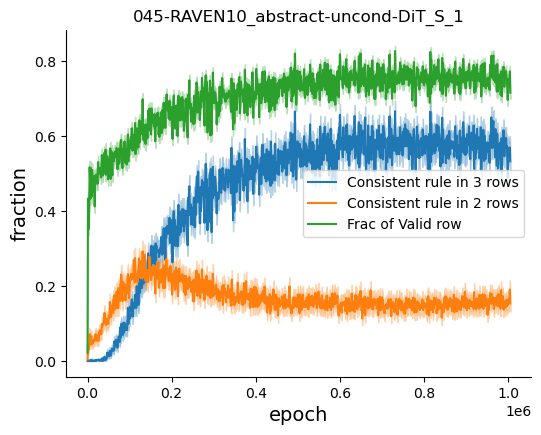

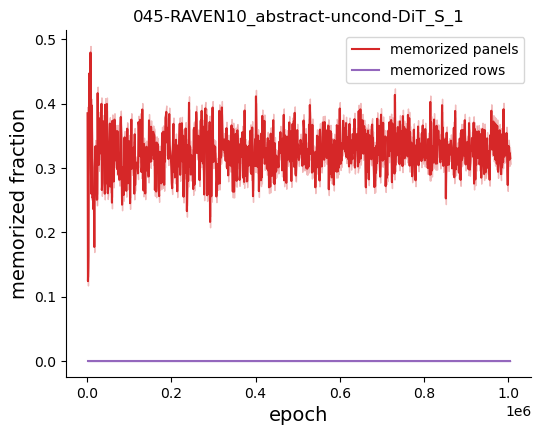

In [50]:
expname = '045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256'
expdir = join(exproot, expname)
args = json.load(open(join(expdir, "args.json")))
log_df = parse_log_file(join(expdir, "log.txt"))
rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency_new.npz'))
stats_df = pd.read_csv(join(expdir, "consistency_new_stats_df.csv"), index_col=0)
mem_df = pd.read_csv(join(expdir, "memorization_stats.csv"), index_col=0)
# visualize_consistency_new(stats_df, title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],)
ax = visualize_consistency_new(stats_df, title_str=expname.split("_2024")[0], ax=None,);
visualize_rule_validity_new(stats_df, title_str=expname.split("_2024")[0], ax=ax,);
ax.set_ylabel("fraction")
# change the legend text
ax.get_legend().texts[0].set_text("Consistent rule in 3 rows")
ax.get_legend().texts[1].set_text("Consistent rule in 2 rows")
ax.get_legend().texts[2].set_text("Frac of Valid row")
saveallforms(figdir, f"{expname}_rule_valid_consistency", figh=ax.figure)
ax2 = visualize_row_panel_memorization(mem_df, title_str=expname.split("_2024")[0], ax=None,);
saveallforms(figdir, f"{expname}_memorization", figh=ax2.figure)

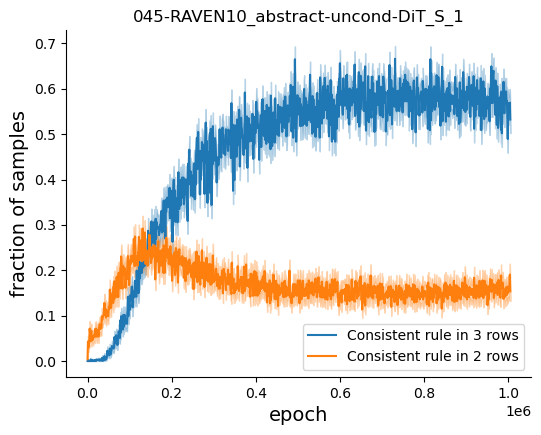

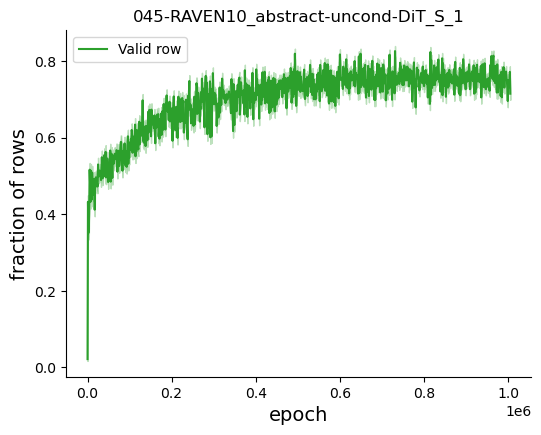

In [52]:
ax = visualize_consistency_new(stats_df, title_str=expname.split("_2024")[0], ax=None,);
ax.set_ylabel("fraction of samples")
ax.get_legend().texts[0].set_text("Consistent rule in 3 rows")
ax.get_legend().texts[1].set_text("Consistent rule in 2 rows")
saveallforms(figdir, f"{expname}_rule_consistency", figh=ax.figure)
ax1 = visualize_rule_validity_new(stats_df, title_str=expname.split("_2024")[0], ax=None,);
ax1.set_ylabel("fraction of rows")
ax1.get_legend().texts[0].set_text("Valid row")
saveallforms(figdir, f"{expname}_rule_validity", figh=ax1.figure)

#### Scratch zone for

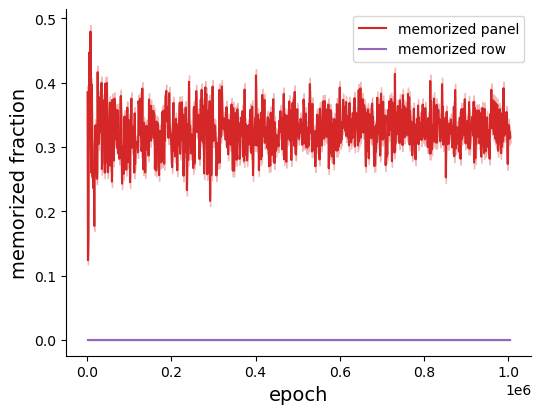

In [38]:
ax = None
if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
row_num = 3
panel_num = 3
sample_num = 1024
mem_panel_cnt = round(mem_df.panel_memfrac * row_num * panel_num * sample_num).astype(int)
mem_row_cnt = round(mem_df.row_memfrac * row_num * sample_num).astype(int)
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI(mem_panel_cnt, 
                        row_num * panel_num * sample_num, alpha=0.05)
shaded_error(ax, mem_df.epoch, mem_df.panel_memfrac,
                CI_low, CI_high, label="memorized panels", color="C3")
CI_low, CI_high = estimate_CI(mem_row_cnt,
                        row_num * sample_num, alpha=0.05)
shaded_error(ax, mem_df.epoch, mem_df.row_memfrac,
                CI_low, CI_high, label="memorized rows", color="C4")
ax.set_ylabel('memorized fraction', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
# ax.set_title(f"{title_str}") # , uncond Diffusion
ax.legend()
# if figdir is not None:
#     fig.savefig(join(figdir,f"{figname}_memorization.pdf"), dpi=300, ) #bbox_inches='tight')
#     fig.savefig(join(figdir,f"{figname}_memorization.png"), dpi=300, ) #bbox_inches='tight')
# return ax
plt.show()

### Synopsis plot

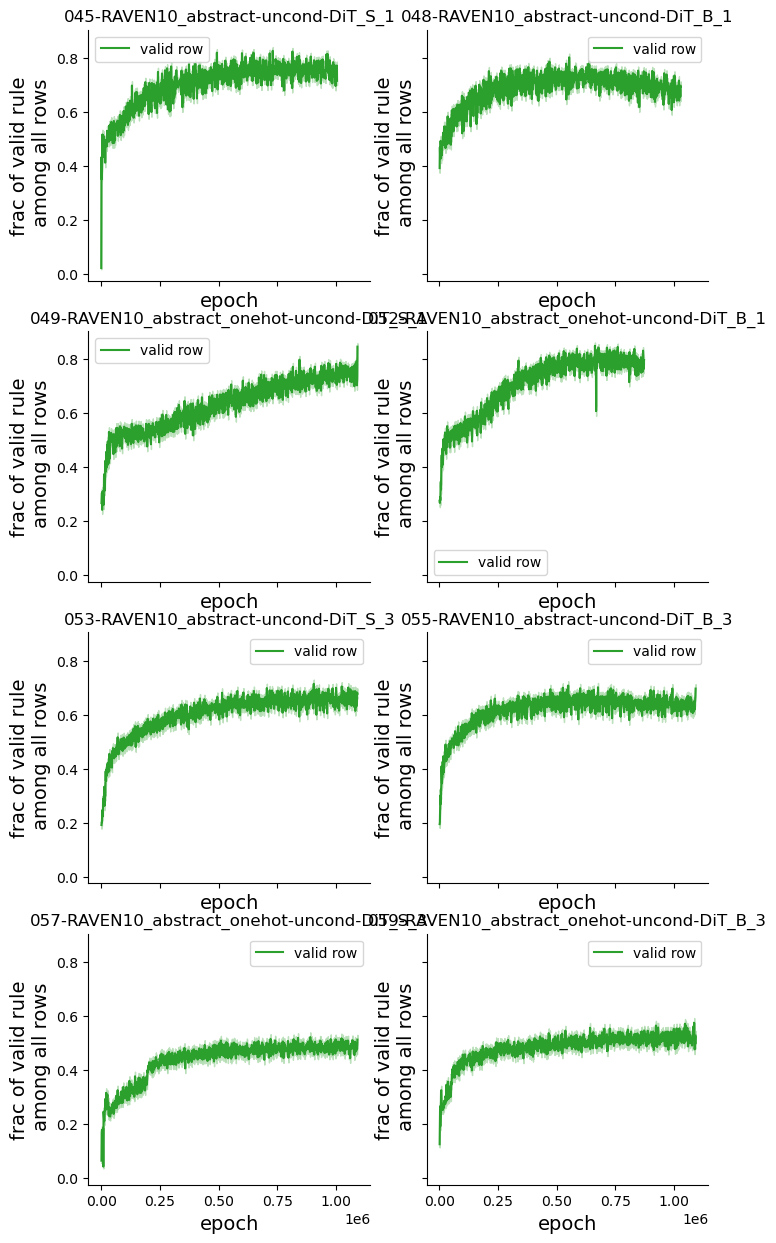

In [18]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figh, axs = plt.subplots(4, 2, figsize=(8, 15), sharex=True, sharey=True)
axs = axs.flatten()
for expi, expname in enumerate(['045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256',
                                '048-RAVEN10_abstract-uncond-DiT_B_1_20240311-1259',
                                '049-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240312-0219',
                                '052-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240312-0222',
                                '053-RAVEN10_abstract-uncond-DiT_S_3_20240312-0231',
                                '055-RAVEN10_abstract-uncond-DiT_B_3_20240312-0233',
                                '057-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240312-2311',
                                '059-RAVEN10_abstract_onehot-uncond-DiT_B_3_20240312-2311',]):
    expdir = join(exproot, expname)
    args = json.load(open(join(expdir, "args.json")))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency_new.npz'))
    log_df = parse_log_file(join(expdir, "log.txt"))
    stats_df = pd.read_csv(join(expdir, "consistency_new_stats_df.csv"), index_col=0)
    # log_df.plot(x="Step", y=["Train Loss"], alpha=0.75, ax=axs[expi])
    # visualize_consistency_new(stats_df, title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],)
    visualize_rule_validity_new(stats_df, title_str=expname.split("_2024")[0], ax=axs[expi],);

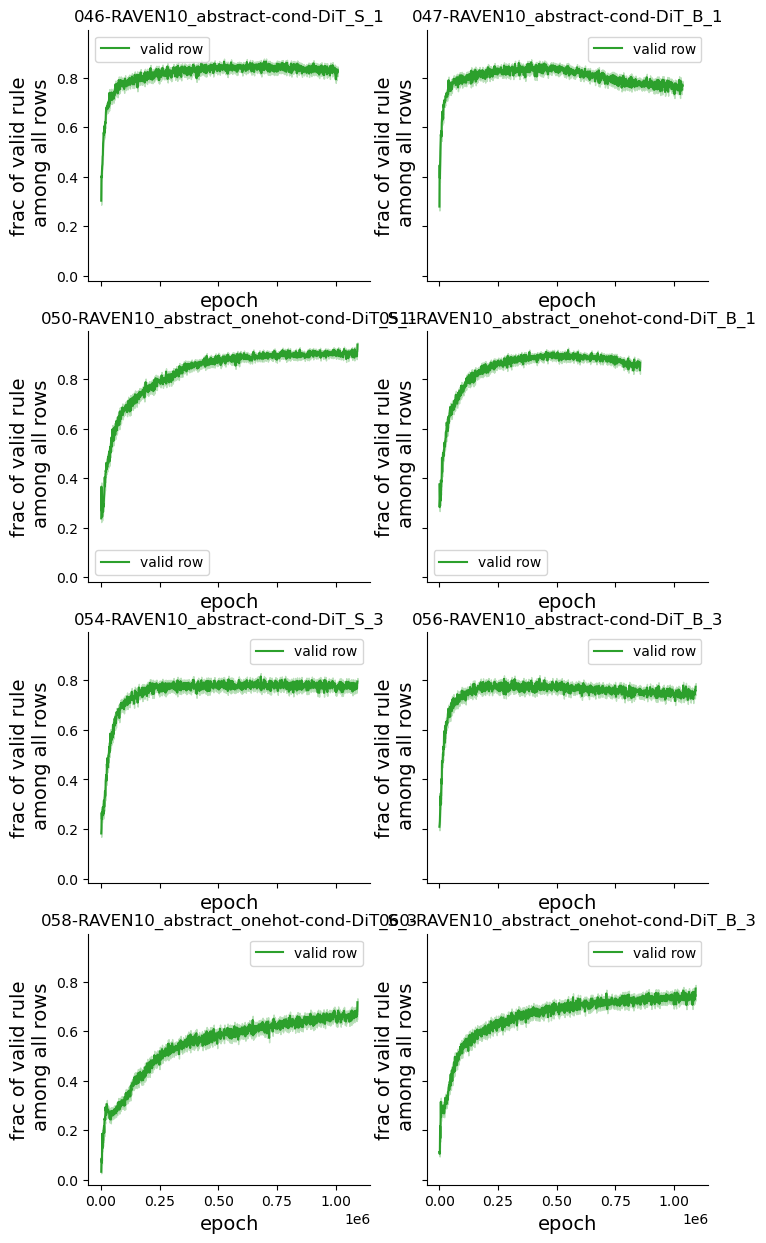

In [19]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figh, axs = plt.subplots(4, 2, figsize=(8, 15), sharex=True, sharey=True)
axs = axs.flatten()
for expi, expname in enumerate(['046-RAVEN10_abstract-cond-DiT_S_1_20240311-1256',
                                '047-RAVEN10_abstract-cond-DiT_B_1_20240311-1259',
                                '050-RAVEN10_abstract_onehot-cond-DiT_S_1_20240312-0219',
                                '051-RAVEN10_abstract_onehot-cond-DiT_B_1_20240312-0222',
                                '054-RAVEN10_abstract-cond-DiT_S_3_20240312-0233',
                                '056-RAVEN10_abstract-cond-DiT_B_3_20240312-0235',
                                '058-RAVEN10_abstract_onehot-cond-DiT_S_3_20240312-2311',
                                '060-RAVEN10_abstract_onehot-cond-DiT_B_3_20240312-2325',]):
    expdir = join(exproot, expname)
    args = json.load(open(join(expdir, "args.json")))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency_new.npz'))
    log_df = parse_log_file(join(expdir, "log.txt"))
    stats_df = pd.read_csv(join(expdir, "consistency_new_stats_df.csv"))
    # log_df.plot(x="Step", y=["Train Loss"], alpha=0.75, ax=axs[expi])
    # visualize_consistency_new(stats_df, title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],)
    visualize_rule_validity_new(stats_df, title_str=expname.split("_2024")[0], ax=axs[expi],);

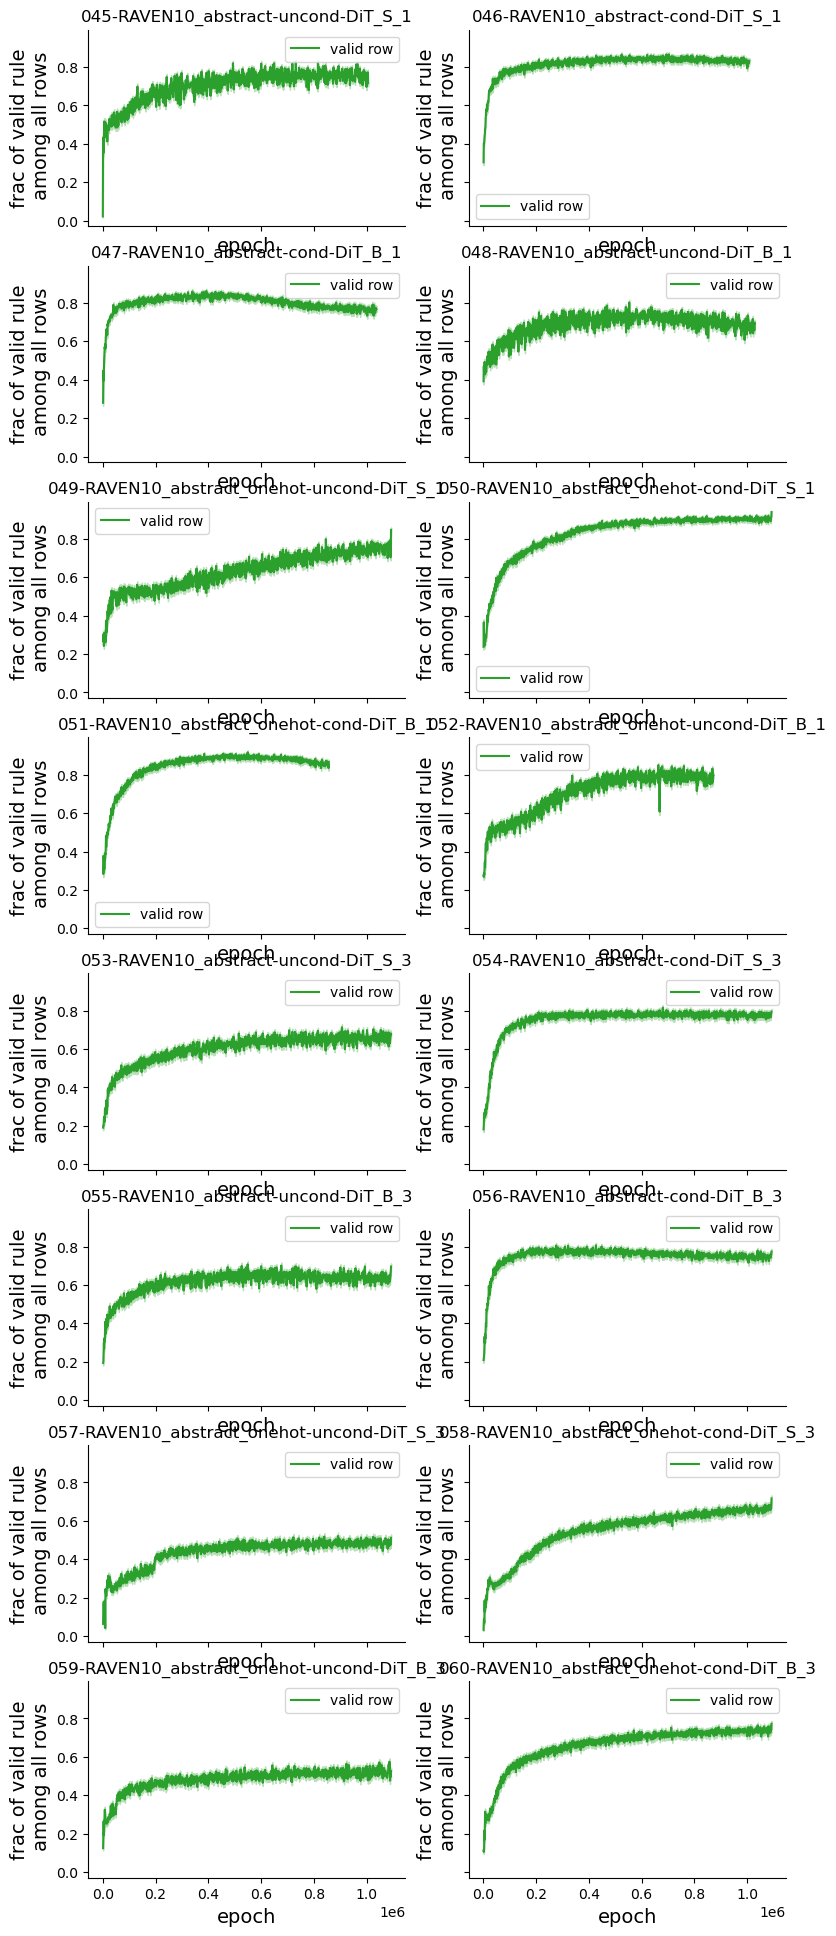

In [15]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figh, axs = plt.subplots(8, 2, figsize=(8, 30), sharex=True, sharey=True)
axs = axs.flatten()
for expi, expname in enumerate(['045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256',
                                '046-RAVEN10_abstract-cond-DiT_S_1_20240311-1256',
                                '047-RAVEN10_abstract-cond-DiT_B_1_20240311-1259',
                                '048-RAVEN10_abstract-uncond-DiT_B_1_20240311-1259',
                                '049-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240312-0219',
                                '050-RAVEN10_abstract_onehot-cond-DiT_S_1_20240312-0219',
                                '051-RAVEN10_abstract_onehot-cond-DiT_B_1_20240312-0222',
                                '052-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240312-0222',
                                '053-RAVEN10_abstract-uncond-DiT_S_3_20240312-0231',
                                '054-RAVEN10_abstract-cond-DiT_S_3_20240312-0233',
                                '055-RAVEN10_abstract-uncond-DiT_B_3_20240312-0233',
                                '056-RAVEN10_abstract-cond-DiT_B_3_20240312-0235',
                                '057-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240312-2311',
                                '058-RAVEN10_abstract_onehot-cond-DiT_S_3_20240312-2311',
                                '059-RAVEN10_abstract_onehot-uncond-DiT_B_3_20240312-2311',
                                '060-RAVEN10_abstract_onehot-cond-DiT_B_3_20240312-2325',]):
    expdir = join(exproot, expname)
    args = json.load(open(join(expdir, "args.json")))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency_new.npz'))
    log_df = parse_log_file(join(expdir, "log.txt"))
    stats_df = pd.read_csv(join(expdir, "consistency_new_stats_df.csv"))
    # log_df.plot(x="Step", y=["Train Loss"], alpha=0.75, ax=axs[expi])
    # visualize_consistency_new(stats_df, title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],)
    visualize_rule_validity_new(stats_df, title_str=expname.split("_2024")[0], ax=axs[expi],);

### Held-out rule analysis

In [54]:
row_table = {
0: "Constant",
1: "Progression neg 2",
2: "Progression neg 1",
3: "Progression pos 1",
4: "Progression pos 2",
5: "Arithmetic pos",
6: "Arithmetic neg",
7: "XOR",
8: "OR",
9: "AND"
}
col_table =  {0: "Shape", 1: "Size", 2: "Color", 3: "Number", 4: "Position"}
entry_table = {}
for i in range(40):
    if i < 37:
        entry_table[i] = f"{row_table[i%10]}-{col_table[i//10]}"
    else:
        entry_table[i] = f"{row_table[i%10]}-{col_table[i//10+1]}"


heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}

def visualize_indiv_rule_dynam(rule_mat, conv_wid=10, heldout_id=[1, 16, 20, 34, 37],
                               titlestr="Valid rule count separated by rule type", ylabel="Count", axs=None):
    # remove top and right spines from plot with plt
    plt.rcParams.update({'font.size': 12})
    if axs is None:
        figh, axs = plt.subplots(4, 10, figsize=(30, 12.5), sharex=True, sharey=True)
    else:
        figh = axs[0,0].get_figure()
    axs_f = axs.flatten()
    for i in range(40):
        ax = axs_f[i]
        # smooth the curve
        smooth_rule_cnt = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
        ax.plot(data['epoch_list'], smooth_rule_cnt, alpha=0.7, )
        ax.set_title(f"R{i}: {entry_table[i]}")
        # change the font color of title to red
        if i in heldout_id:
            ax.title.set_color('red')
        if i >= 30:
            ax.set_xlabel("generation")
        if i % 10 == 0:
            ax.set_ylabel(ylabel)
    figh.suptitle(titlestr, fontsize=20)
    figh.tight_layout()
    figh.show()
    return figh, axs

Found args.json file. Using heldout_id: [1, 16, 20, 34, 37] from train_inputs_new.pt.


100%|██████████| 1006/1006 [00:00<00:00, 23122.41it/s]
/tmp/ipykernel_4060495/3696630765.py:59: UserWarning: The figure layout has changed to tight
  figh.tight_layout()


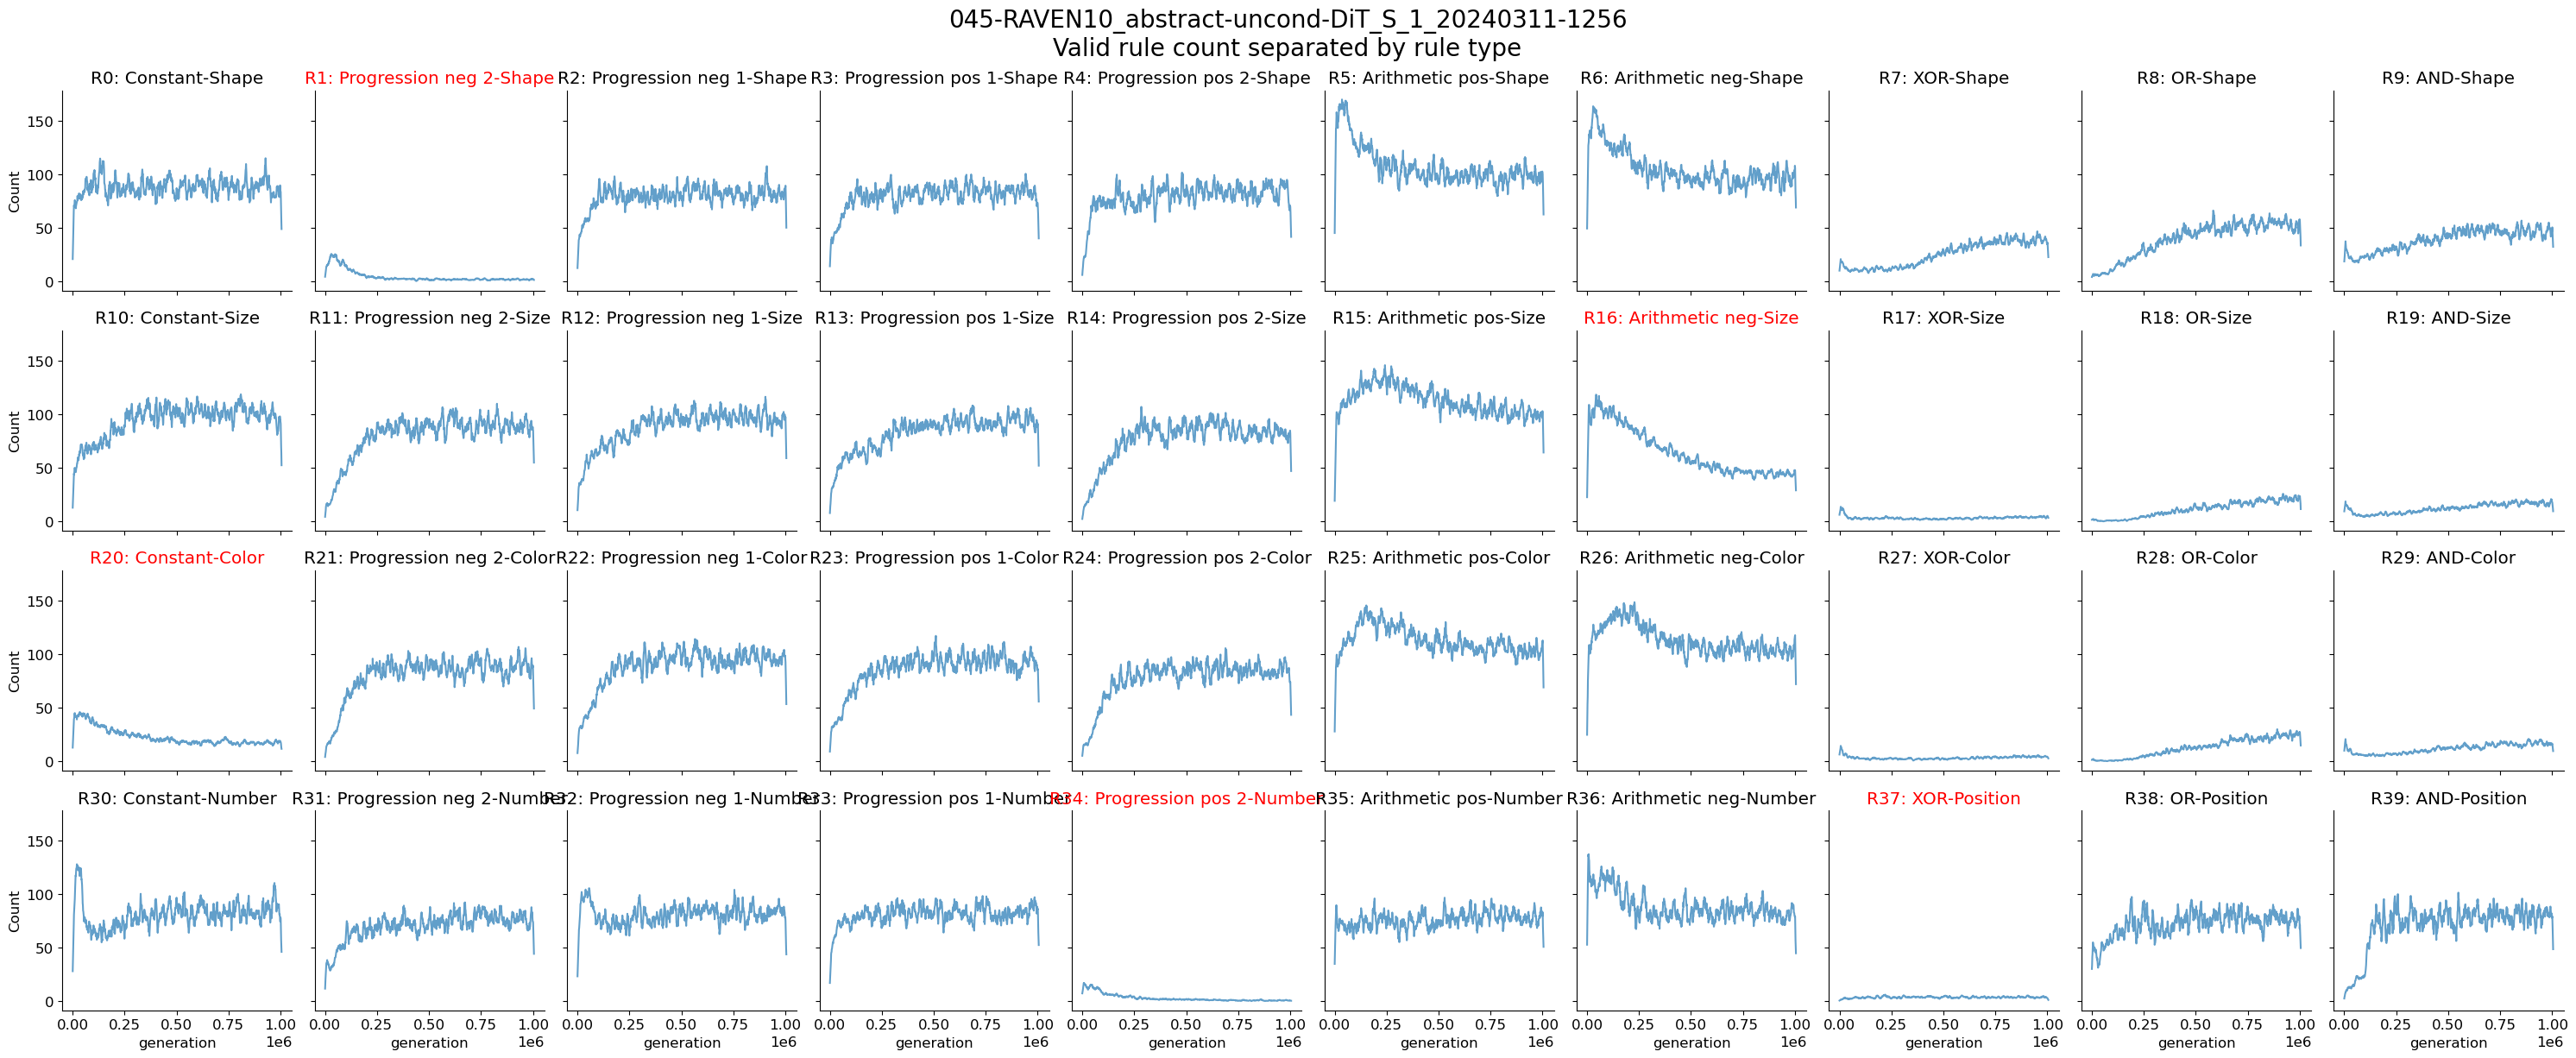

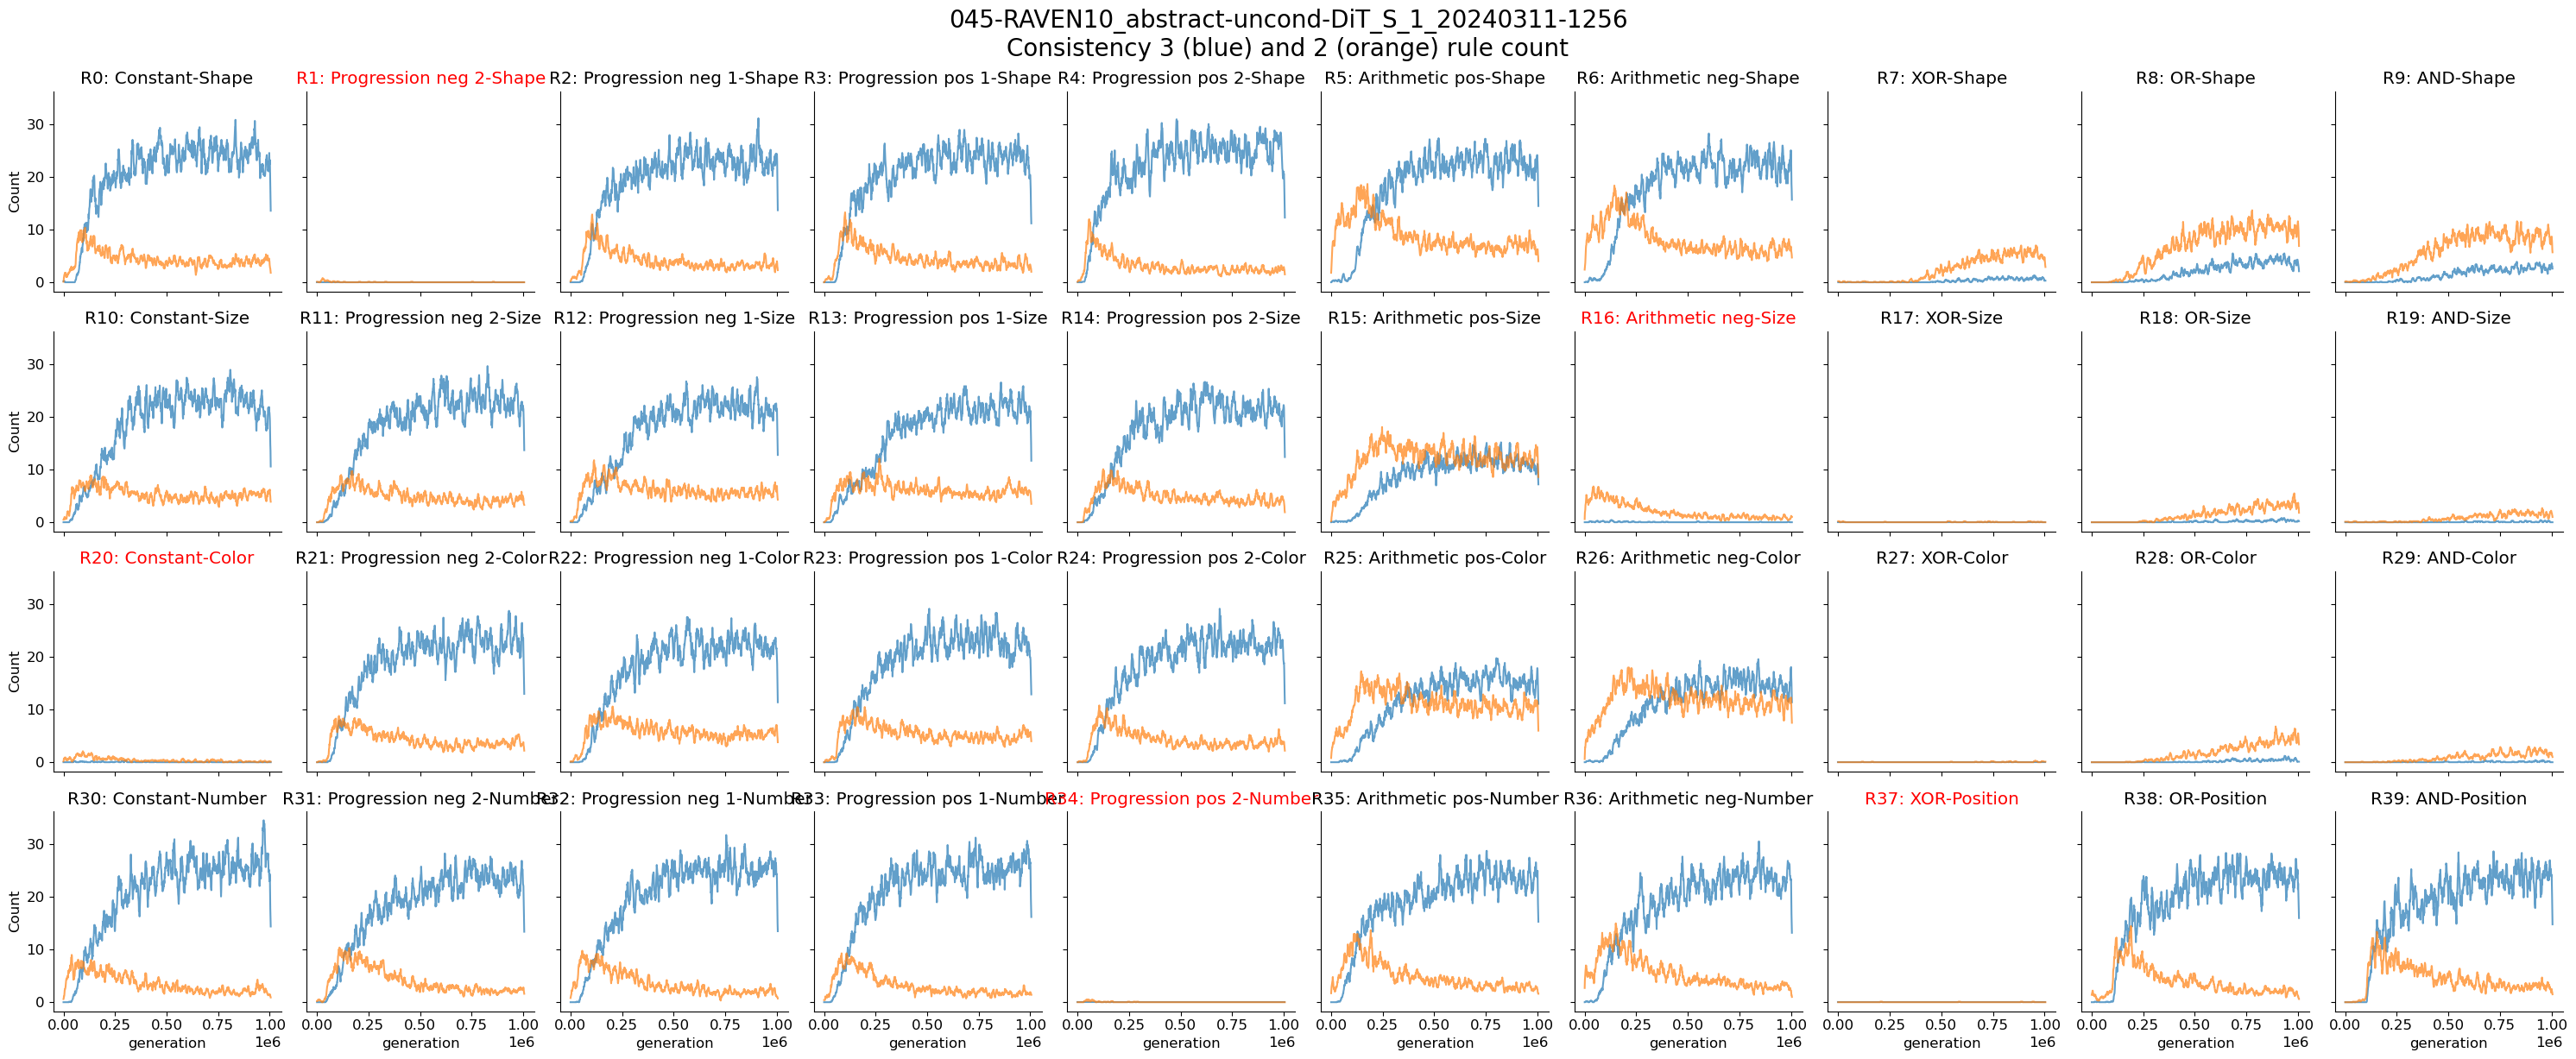

In [55]:
from copy import deepcopy
from tqdm import trange
expname = '045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256'
expdir = join(exproot, expname)
if os.path.exists(join(expdir, "args.json")):
    with open(join(expdir, "args.json"), 'r') as f:
        DiTargs = edict(json.load(f))
    train_data_fn = DiTargs['train_attr_fn']
    heldout_id = heldout_id_dict[train_data_fn]
    print(f"Found args.json file. Using heldout_id: {heldout_id} from {train_data_fn}.")
else:
    print("No args.json file found. Using default values.")
    heldout_id = [1, 16, 20, 34, 37]
data = np.load(join(expdir, "samples_inferred_rule_consistency_new.npz"), allow_pickle=True)
list(data.keys())
rule_list_all = deepcopy(data['rule_list_all'])
consistency_all = deepcopy(data['consistency_all'])

# each element in the rule rule_pool_all is a list of rules for all the samples in the corresponding generation
rule_pool_all = []
for i in trange(len(data['epoch_list'])):
    rule_pool = np.concatenate(list(rule_list_all[i,:,:].flatten())).astype(int)
    rule_pool_all.append(rule_pool)
# plot the number of rules == rule_i for each generation
rule_cnt_mat = np.zeros((len(data['epoch_list']), 40))
for i in trange(len(data['epoch_list'])):
    rule_pool = rule_pool_all[i]
    rule_uniq, counts = np.unique(rule_pool, return_counts=True)
    rule_cnt_mat[i, rule_uniq] = counts

cons3_rule_pool_all = []
cons2_rule_pool_all = []
for i in trange(len(data['epoch_list'])):
    rule_pool = np.concatenate(list(consistency_all[i,0,:].flatten())).astype(int)
    cons3_rule_pool_all.append(rule_pool)
    rule_pool = np.concatenate(list(consistency_all[i,1,:].flatten())).astype(int)
    cons2_rule_pool_all.append(rule_pool)

cons3_rule_cnt_mat = np.zeros((len(data['epoch_list']), 40))
cons2_rule_cnt_mat = np.zeros((len(data['epoch_list']), 40))
for i in trange(len(data['epoch_list'])):
    rule_pool = cons3_rule_pool_all[i]
    rule_uniq, counts = np.unique(rule_pool, return_counts=True)
    cons3_rule_cnt_mat[i, rule_uniq] = counts
    rule_pool = cons2_rule_pool_all[i]
    rule_uniq, counts = np.unique(rule_pool, return_counts=True)
    cons2_rule_cnt_mat[i, rule_uniq] = counts
    
# figdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Figures_newrule"
figh, axs = visualize_indiv_rule_dynam(rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                        titlestr=f"{expname}\nValid rule count separated by rule type")
saveallforms(figdir, f"{expname}_indiv_rule_validity", figh)


figh, axs = visualize_indiv_rule_dynam(cons3_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                       titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", )
figh, axs = visualize_indiv_rule_dynam(cons2_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                       titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", axs=axs)
saveallforms(figdir, f"{expname}_indiv_rule_consistency", figh)

In [68]:
np.ones((conv_wid, 1))/conv_wid

array([[0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1]])

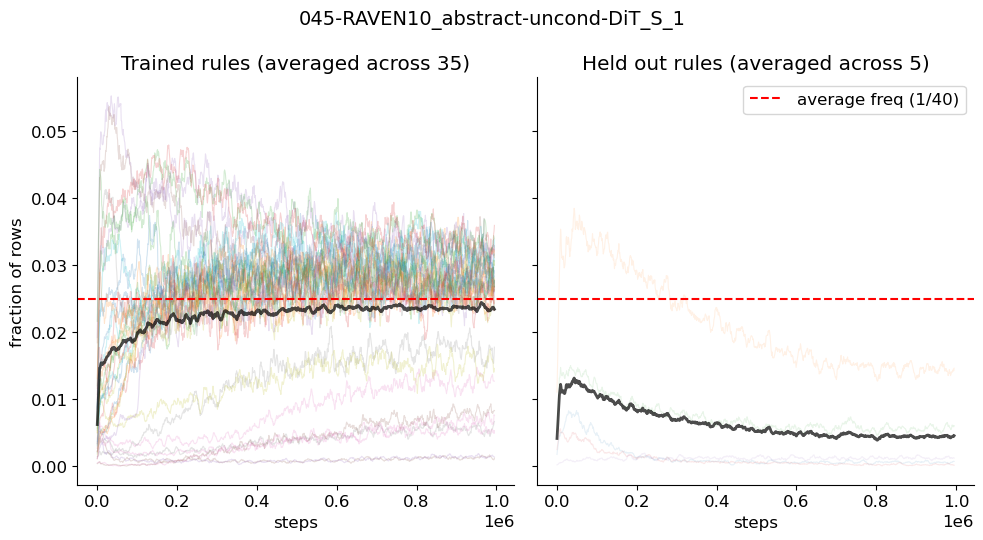

In [92]:
rule_mat = rule_cnt_mat
conv_wid = 11
inmask = np.ones(40, dtype=bool)
inmask[heldout_id] = False
figh, axs = plt.subplots(1, 2, figsize=(10, 5.5), sharex=True, sharey=True)

avg_baseline = 1 / 40 
avg_baseline_2 = 1 / sum(inmask) # 1/35
smooth_rule_mat = np.zeros_like(rule_mat)
for i in range(40):
    smooth_rule_mat[:,i] = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
slc = slice(None, -conv_wid + 1)
axs[0].plot(data['epoch_list'][slc], smooth_rule_mat[slc,inmask] / row_num / sample_num, alpha=0.2, label=None, lw=0.8)
axs[0].plot(data['epoch_list'][slc], smooth_rule_mat[slc,inmask].mean(axis=1) / row_num / sample_num, alpha=0.7, color='k', lw=2)
axs[0].axhline(avg_baseline, color='r', linestyle='--', label="average freq (1/40)")
# axs[0].axhline(avg_baseline_2, color='g', linestyle='--', label="avg baseline 2")
axs[0].set_title("Trained rules (averaged across 35)")
axs[1].plot(data['epoch_list'][slc], smooth_rule_mat[slc,~inmask] / row_num / sample_num, alpha=0.1, label=None, lw=0.8)
axs[1].plot(data['epoch_list'][slc], smooth_rule_mat[slc,~inmask].mean(axis=1) / row_num / sample_num, alpha=0.7, color='k', lw=2)
axs[1].axhline(avg_baseline, color='r', linestyle='--', label="average freq (1/40)")
plt.legend()
# axs[1].axhline(avg_baseline_2, color='g', linestyle='--', label="avg baseline 2")
axs[1].set_title("Held out rules (averaged across 5)")
axs[0].set_ylabel("fraction of rows")
axs[0].set_xlabel("steps")
axs[1].set_xlabel("steps")
# axs_f = axs.flatten()
# for i in range(40):
#     ax = axs_f[i]
#     # smooth the curve
#     smooth_rule_cnt = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
#     ax.plot(data['epoch_list'], smooth_rule_cnt, alpha=0.7, )
#     ax.set_title(f"R{i}: {entry_table[i]}")
#     # change the font color of title to red
#     if i in heldout_id:
#         ax.title.set_color('red')
# figh.suptitle(titlestr, fontsize=20)
figh.suptitle(expname.split("_2024")[0], fontsize=14)
figh.tight_layout()
saveallforms(figdir, f"{expname}_train_vs_heldout_validity", figh)
figh.show()
# return figh, axs

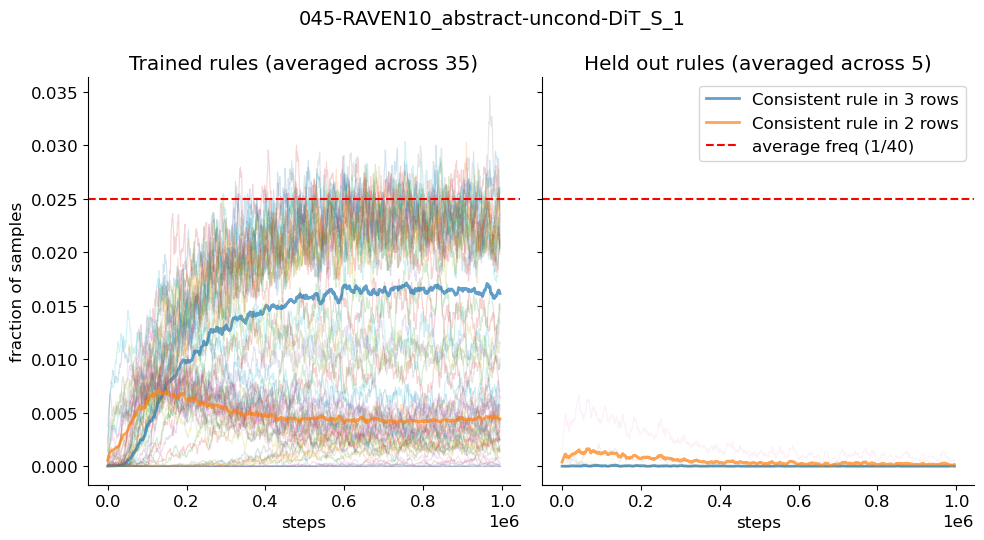

In [93]:

rule_mat = cons3_rule_cnt_mat

inmask = np.ones(40, dtype=bool)
inmask[heldout_id] = False

conv_wid = 11
smooth_rule_mat = np.zeros_like(rule_mat)
for i in range(40):
    smooth_rule_mat[:,i] = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
slc = slice(None, -conv_wid + 1)

avg_baseline = 1 / 40 
avg_baseline_2 = 1 / sum(inmask) # 1/35
figh, axs = plt.subplots(1, 2, figsize=(10, 5.5), sharex=True, sharey=True)
axs[0].plot(data['epoch_list'][slc], smooth_rule_mat[slc,inmask] / sample_num, alpha=0.2, label=None, lw=0.8)
axs[0].plot(data['epoch_list'][slc], smooth_rule_mat[slc,inmask].mean(axis=1) / sample_num, alpha=0.7, color='C0', lw=2, label="Consistent rule in 3 rows")
# axs[0].axhline(avg_baseline, color='r', linestyle='--', label="average freq (1/40)")
# axs[0].axhline(avg_baseline_2, color='g', linestyle='--', label="avg baseline 2")
axs[0].set_title("Trained rules (averaged across 35)")
axs[1].plot(data['epoch_list'][slc], smooth_rule_mat[slc,~inmask] / sample_num, alpha=0.1, label=None, lw=0.8)
axs[1].plot(data['epoch_list'][slc], smooth_rule_mat[slc,~inmask].mean(axis=1) / sample_num, alpha=0.7, color='C0', lw=2, label="Consistent rule in 3 rows")
# axs[1].axhline(avg_baseline, color='r', linestyle='--', label="average freq (1/40)")
# plt.legend()
# axs[1].axhline(avg_baseline_2, color='g', linestyle='--', label="avg baseline 2")
axs[1].set_title("Held out rules (averaged across 5)")
axs[0].set_ylabel("fraction of samples")
axs[0].set_xlabel("steps")
axs[1].set_xlabel("steps")


rule_mat = cons2_rule_cnt_mat

inmask = np.ones(40, dtype=bool)
inmask[heldout_id] = False

conv_wid = 11
smooth_rule_mat = np.zeros_like(rule_mat)
for i in range(40):
    smooth_rule_mat[:,i] = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
slc = slice(None, -conv_wid + 1)

avg_baseline = 1 / 40 
avg_baseline_2 = 1 / sum(inmask) # 1/35
# figh, axs = plt.subplots(1, 2, figsize=(10, 5.5), sharex=True, sharey=True)
axs[0].plot(data['epoch_list'][slc], smooth_rule_mat[slc,inmask] / sample_num, alpha=0.2, label=None, lw=0.8)
axs[0].plot(data['epoch_list'][slc], smooth_rule_mat[slc,inmask].mean(axis=1) / sample_num, alpha=0.7, color='C1', lw=2, label="Consistent rule in 2 rows")
axs[0].axhline(avg_baseline, color='r', linestyle='--', label="average freq (1/40)")
# axs[0].axhline(avg_baseline_2, color='g', linestyle='--', label="avg baseline 2")
axs[0].set_title("Trained rules (averaged across 35)")
axs[1].plot(data['epoch_list'][slc], smooth_rule_mat[slc,~inmask] / sample_num, alpha=0.1, label=None, lw=0.8)
axs[1].plot(data['epoch_list'][slc], smooth_rule_mat[slc,~inmask].mean(axis=1) / sample_num, alpha=0.7, color='C1', lw=2, label="Consistent rule in 2 rows")
axs[1].axhline(avg_baseline, color='r', linestyle='--', label="average freq (1/40)")
plt.legend()
# axs[1].axhline(avg_baseline_2, color='g', linestyle='--', label="avg baseline 2")
axs[1].set_title("Held out rules (averaged across 5)")
axs[0].set_ylabel("fraction of samples")
axs[0].set_xlabel("steps")
axs[1].set_xlabel("steps")
# axs_f = axs.flatten()
# for i in range(40):
#     ax = axs_f[i]
#     # smooth the curve
#     smooth_rule_cnt = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
#     ax.plot(data['epoch_list'], smooth_rule_cnt, alpha=0.7, )
#     ax.set_title(f"R{i}: {entry_table[i]}")
#     # change the font color of title to red
#     if i in heldout_id:
#         ax.title.set_color('red')
figh.suptitle(expname.split("_2024")[0], fontsize=14)
figh.tight_layout()
saveallforms(figdir, f"{expname}_train_vs_heldout_consistency", figh)
figh.show()
# return figh, axs